here a reference for markov chains : http://www.statslab.cam.ac.uk/~rrw1/markov/M.pdf 

paper where use CTMC in a cold atoms experiment, but different to our: A continuous source of spin-polarized cold atoms https://hal.archives-ouvertes.fr/file/index/docid/793482/filename/article_submission_2.pdf

the dynamics of a dipolar trap can be described by a markov chain

the differential equation is

$$ \frac{d\bar{v}}{dt} = \hat{P} \bar{v}$$

where $\bar{v}$ is the probability vector and $\hat{P}$ is the markov probability matrix.

the site $i$ of the chain corrisponds to the state with $i$ atoms in the dipolar trap.

$$ \hat{P} =
    \begin{pmatrix}
    -p & p & 0  & \dots & 0 \\
    p_{10} & q_1 & p  & \dots & 0 \\
    0 & p_{21} & q_2  & \dots & 0 \\
    \vdots & \vdots  & \vdots & \ddots & p \\
    0 & 0 & 0  & p_{i,i-1} &  q_i  \\
    \end{pmatrix}
$$

with 
- $p = R$ is the loading probability
- $p_{i, i-1} = - i (\gamma + \beta(i-1)) $ is the loss probability
- $q_i = - p_{i, i-1} -p$


the initial condition is $v_0 = 1 \ \ ; \ \ v_i = 0 \ \ \forall i \neq 0$ 

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy.stats as scst

class markov_chain_FORT:
    def __init__(self, R, gamma, beta, truncation_size, method="model_1") -> None:
        self.R = R
        self.gamma = gamma
        self.beta = beta
        self.truncation_size = truncation_size
        self.transition_matrix = self.get_transition_matrix(method)
        pass

    def get_transition_matrix(self, method):
        if method == "model_1":
            return self.get_transition_matrix_model_1()
        if method == "model_2":
            return self.get_transition_matrix_model_1()
        print("method must be model_1 or model_2")
        return
    
    def get_transition_matrix_model_1(self):
        P = np.zeros([self.truncation_size, self.truncation_size])
        P[0, 0] = - self.R
        P[0, 1] = self.R
        for i in range(1, self.truncation_size-1):
            p_i = i*(self.gamma+self.beta*(i-1))
            P[i, i+1] = self.R
            P[i, i] = - self.R - p_i
            P[i, i-1] = p_i
        P[self.truncation_size-1, self.truncation_size-1] = - (self.truncation_size-1)*(self.gamma+self.beta*((self.truncation_size-1)-1)) - self.R
        P[self.truncation_size-1, self.truncation_size-2] = (self.truncation_size-1)*(self.gamma+self.beta*((self.truncation_size-1)-1))
        return P
    
    def get_transition_matrix_model_2(self):
        P = np.zeros([self.truncation_size, self.truncation_size])
        P[0, 0] = - self.R
        P[0, 1] = self.R
        P[1, 0] = self.gamma
        P[1, 1] = - self.R - self.gamma
        P[1, 2] = self.R
        for i in range(2, self.truncation_size-1):
            p_i_1 = i*self.gamma
            p_i_2 = self.beta/2*(i-1)*i
            P[i, i+1] = self.R
            P[i, i] = - self.R - p_i_1 - p_i_2
            P[i, i-1] = p_i_1
            P[i, i-2] = p_i_2
        P[self.truncation_size-1, self.truncation_size-1] = - (self.truncation_size-1)*(self.gamma+self.beta/2*((self.truncation_size-1)-1)) - self.R
        P[self.truncation_size-1, self.truncation_size-2] = (self.truncation_size-1)*self.gamma
        P[self.truncation_size-1, self.truncation_size-3] = (self.truncation_size-1)*self.beta/2*((self.truncation_size-1)-1)
        return P

    def function_(self, t, v):
        return np.dot(v, self.transition_matrix)

    def evolve(self, v0, time, steps):
        self.evo = solve_ivp(self.function_, t_span=(0,time), y0=v0, t_eval=np.linspace(0, time, steps))
        return

    def show_matrix(self):
        from sympy import Matrix
        return Matrix(self.transition_matrix)
    
    def plot_mandel_Q(self):
        means_ = []
        vars_ = []
        Qs_ = []
        for i in range(len(self.evo.y[0])):
            mean_, var_, mandel_Q_ = mean_var_mandel_Q(self.evo.y[:,i])
            means_.append(mean_)
            vars_.append(var_)
            Qs_.append(mandel_Q_)

        def fun_paper(t, N):
            return self.R - self.gamma*N - self.beta*N*(N-1)

        sol_paper = solve_ivp(fun=fun_paper, t_span=(0, self.evo.t[-1]), y0=[0], t_eval=np.linspace(0, self.evo.t[-1], len(self.evo.t))) 

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()

        #print(sol_paper.y[-1], sol_paper.t[-1])
        #print(means_[-1], self.evo.t[-1])

        ax1.plot(self.evo.t, Qs_, label="mandel Q", color="green")
        ax1.set_ylabel("mandel Q", fontsize=15)
        #ax1.set_xscale("log")
        ax1.set_xlabel(r"time", fontsize=15)
        #ax2.plot([0, self.evo.t[-1]],[1,1],c="gray",linestyle="--",alpha=0.7, label=r"$\langle N \rangle=1$")
        ax2.plot(self.evo.t, means_, color="red",label=r"$\langle N \rangle$")
        ax2.plot(self.evo.t, sol_paper.y[0], label="paper")
        #vars_ = np.array(vars_)#*self.beta
        #ax2.plot(self.evo.t, vars_, color="blue", label="var")
        #ax2.plot(self.evo.t, (sol_paper.y[0]-means_)/self.beta, label="diff")

        ax2.set_ylabel(r"$\langle N \rangle$", fontsize=15)
        #ax2.set_xscale("log")

        fig.legend(loc=(0.15,0.7), fontsize=15)

        plt.show()
        return

def mean_var_mandel_Q(probability_vec):
    mean = 0
    men_2 = 0
    for i in range(len(probability_vec)):
        mean += i*probability_vec[i]
        men_2 += i**2*probability_vec[i]
    variance = men_2 - mean**2
    Q = variance/mean - 1
    return mean, variance, Q


In [2]:
trunc = 50
time = 1  # [ms]
steps = 1000

mu_poisson = 10

v0 = np.zeros(trunc)
for i in range(trunc):
    v0[i] = scst.poisson.pmf(k=i, mu = mu_poisson)

R = 0  # [kHz]
gamma = 0.1  # [kHz]
beta = 1  # [kHz]

print(R, gamma, beta)

mcF = markov_chain_FORT(R, gamma, beta, trunc, method="model_2")
mcF.evolve(v0, time, steps)


0 0.1 1


In [3]:
#for i in range(trunc):
#    plt.plot(mcF.evo.y[i], label="%d"%i)
#plt.plot(evo.y[29], label="%d"%29)
#plt.legend()
#plt.show()

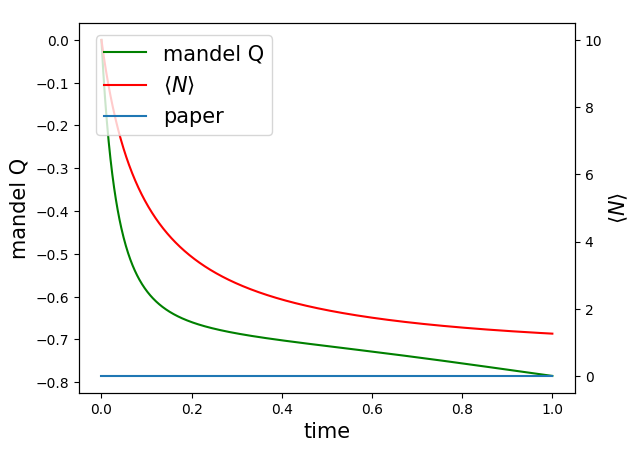

In [4]:
mcF.plot_mandel_Q()

In [5]:
mean_var_mandel_Q(mcF.evo.y[:,-1])

(1.25818391814038, 0.2700722847775838, -0.7853475307673969)

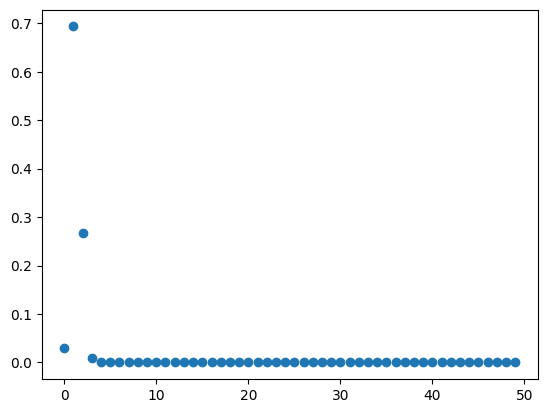

In [6]:
plt.plot(mcF.evo.y[:,-1], "o")
plt.show()

## case $\gamma = 0$

next i will compute the stationary distribution given the parameters in imput

in the case $\gamma = 0$ and $\beta \neq 0$ the stationary state distribution is

$$ p_i = \frac{(R/\beta)^{i-\frac{1}{2}}}{i!(i-1)!} \frac{1}{I_1(2\sqrt{R/\beta})} $$

where 

$$ I_n(z) = \frac{1}{\pi} \int_0^\pi e^{z\cos(\theta)}\cos(n\theta) d\theta $$

In [7]:
import scipy.integrate as spI
from scipy.special import factorial

def bessel_I_1(z):
    integrand = lambda theta: np.exp(z*np.cos(theta))*np.cos(theta)
    res = spI.quad(integrand, 0, np.pi)
    return res[0]/np.pi

def probability_N_beta_zero(i):
    return (R/beta)**(i-0.5)/(factorial(i)*factorial(i-1)*bessel_I_1(2*(R/beta)**0.5))

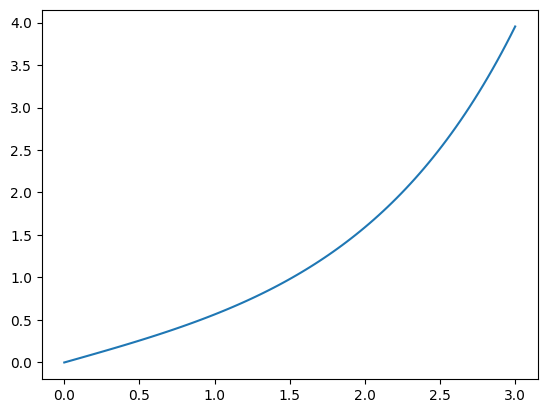

In [8]:
x = np.linspace(0,3, 100)
I1 = [bessel_I_1(xi) for xi in x]

plt.plot(x, I1)
plt.show()

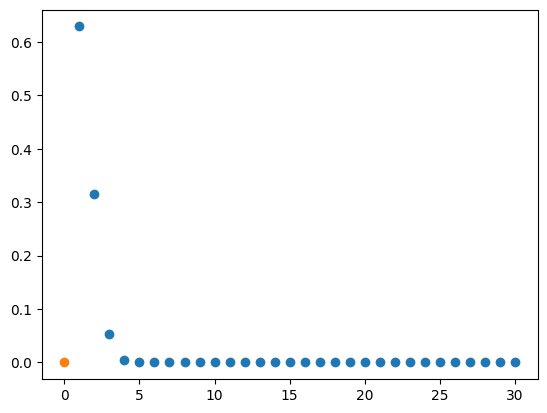

(1.4331274267223117, 0.3792732054985968, -0.7353527687583037)


In [9]:
N_max = 30
bins = np.linspace(1, N_max, N_max)

R = 1
beta = 1

p_i = probability_N_beta_zero(bins)
good_p_i = np.zeros(len(p_i)+1)
good_p_i[0] = 0
good_p_i[1:] = p_i

plt.plot(bins, p_i, "o")
plt.plot(0,0, "o")
plt.show()

print(mean_var_mandel_Q(good_p_i))

In [10]:
p_i[0]

0.6286790080869864

here the parameter is $R/\beta$, so now I study the statistics varing this value.

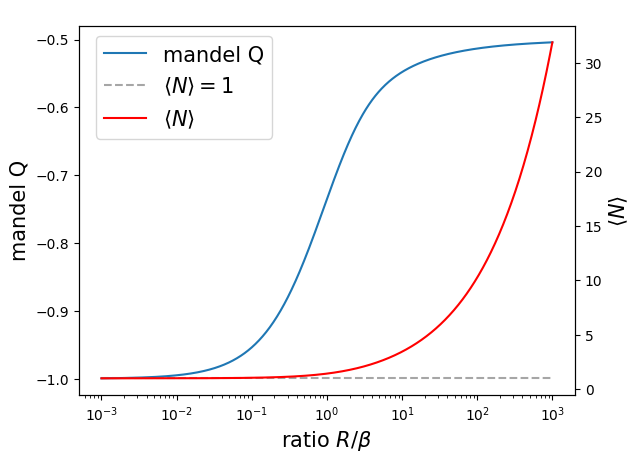

In [11]:
range_ratio = 10**(np.linspace(-3,3, 1000))

N_max = 60
bins = np.linspace(1, N_max, N_max)

Qs_ = []
means_ = []
vars_ = []

for ratio_R_beta in range_ratio:
    R = 1
    beta = 1/ratio_R_beta
    
    p_i = probability_N_beta_zero(bins)
    good_p_i = np.zeros(len(p_i)+1)
    good_p_i[0] = 0
    good_p_i[1:] = p_i
    new_mean, new_var, new_Q = mean_var_mandel_Q(good_p_i)
    Qs_.append(new_Q)
    means_.append(new_mean)
    vars_.append(new_var)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(range_ratio, Qs_, label="mandel Q")
ax1.set_ylabel("mandel Q", fontsize=15)
ax1.set_xscale("log")
ax1.set_xlabel(r"ratio $R/\beta$", fontsize=15)
ax2.plot([min(range_ratio), max(range_ratio)],[1,1],c="gray",linestyle="--",alpha=0.7, label=r"$\langle N \rangle=1$")
ax2.plot(range_ratio, means_, color="red",label=r"$\langle N \rangle$")
ax2.set_ylabel(r"$\langle N \rangle$", fontsize=15)
ax2.set_xscale("log")

fig.legend(loc=(0.15,0.7), fontsize=15)

plt.show()


##  general case $\gamma \neq 0 $ ; $ \beta \neq 0$

$$  \frac{1}{p_0} = \sum_{i = 0}^{\infty} \frac{ R^i /i!}{\prod_{j=1}^{i} (\gamma + \beta(j-1))} = \left(\sqrt{\frac{R}{\beta}}\right)^{1-\gamma/\beta}   I_{\frac{\gamma}{\beta}-1} \left(2\sqrt{\frac{R}{\beta}}\right) \Gamma \left(\frac{\gamma}{\beta}\right)   $$

so

$$ p_i = \frac{  \Gamma \left( \frac{\gamma}{\beta} \right) \left( \frac{R}{\beta} \right)^i  }{\Gamma\left( i+1 \right) \Gamma \left( \frac{\gamma}{\beta}+i \right) }  p_0$$

from the equation
$$
R - \gamma N - \beta N(N-1) = 0
$$
$$
- \beta N^2 - (\gamma-\beta) N +R = 0
$$
$$
N = \frac{(\gamma - \beta) + \sqrt{(\gamma - \beta)^2 + 4R \beta }}{ 2 \beta}
$$ 

In [12]:
from scipy.special import iv as BesselI
from scipy.special import gamma as Gamma

def probability_N(i):
    p_0 = 1/(  np.sqrt(R/beta)**(1-gamma/beta) * BesselI(gamma/beta-1, 2*np.sqrt(R/beta)) * Gamma(gamma/beta)  )
    # old = p_0 = -1/((gamma *(np.sqrt(R)/np.sqrt(beta))**(gamma/beta) - np.sqrt(beta) * np.sqrt(R) *BesselI(-1 + gamma/beta, (2*np.sqrt(R))/np.sqrt(beta))* Gamma((beta + gamma)/beta))/(gamma *(np.sqrt(R)/np.sqrt(beta))**(gamma/beta)))
    #prod = 1
    #for j in range(1,i+1):
    #    prod = prod * j * (gamma + beta * (j-1))
    # old prod = beta**i * Gamma(i+1) * Gamma(gamma/beta+i) / Gamma(gamma/beta) #+ gamma
    p_i = p_0 * Gamma(gamma/beta)*(R/beta)**i / (Gamma(i+1)*Gamma(gamma/beta+i))
    # old return p_0*R**i/prod
    return p_i

def log_probability_N(i):
    log_p_0 = -(  np.log(np.sqrt(R/beta)**(1-gamma/beta)) + np.log( BesselI(gamma/beta-1, 2*np.sqrt(R/beta)) ) + np.log( Gamma(gamma/beta) ) )
    # old = p_0 = -1/((gamma *(np.sqrt(R)/np.sqrt(beta))**(gamma/beta) - np.sqrt(beta) * np.sqrt(R) *BesselI(-1 + gamma/beta, (2*np.sqrt(R))/np.sqrt(beta))* Gamma((beta + gamma)/beta))/(gamma *(np.sqrt(R)/np.sqrt(beta))**(gamma/beta)))
    #prod = 1
    #for j in range(1,i+1):
    #    prod = prod * j * (gamma + beta * (j-1))
    # old prod = beta**i * Gamma(i+1) * Gamma(gamma/beta+i) / Gamma(gamma/beta) #+ gamma
    log_p_i = log_p_0 + np.log(Gamma(gamma/beta)) + i*np.log(R/beta) - np.log(Gamma(i+1)) - np.log(Gamma(gamma/beta+i))
    # old return p_0*R**i/prod
    return log_p_i


In [13]:
probability_N(1)

0.0007049805887976163

In [14]:
#prod = beta**i * Gamma(i+1) * Gamma(gamma/beta+i) / Gamma(gamma/beta)

/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_50972/2670147198.py:16: RuntimeWarning: divide by zero encountered in log
  log_p_0 = -(  np.log(np.sqrt(R/beta)**(1-gamma/beta)) + np.log( BesselI(gamma/beta-1, 2*np.sqrt(R/beta)) ) + np.log( Gamma(gamma/beta) ) )
/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_50972/2670147198.py:22: RuntimeWarning: invalid value encountered in double_scalars
  log_p_i = log_p_0 + np.log(Gamma(gamma/beta)) + i*np.log(R/beta) - np.log(Gamma(i+1)) - np.log(Gamma(gamma/beta+i))
/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_50972/4263714433.py:110: RuntimeWarning: invalid value encountered in double_scalars
  mean += i*probability_vec[i]
/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_50972/4263714433.py:111: RuntimeWarning: invalid value encountered in double_scalars
  men_2 += i**2*probability_vec[i]


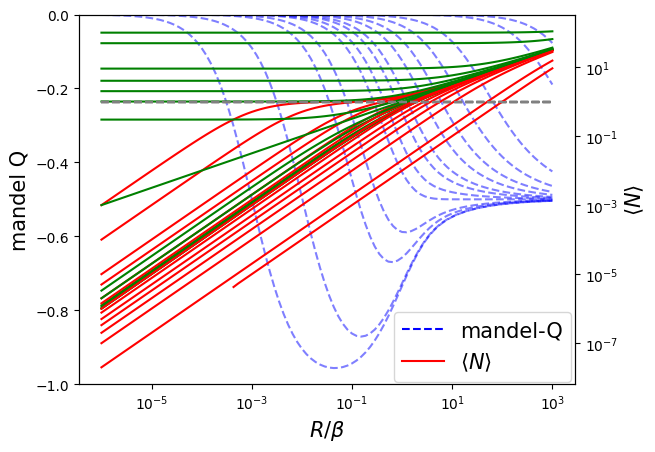

In [15]:
N_max = 200
bins = np.linspace(0, N_max, N_max)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

range_R = 10**(np.linspace(-6,3, 100))
beta = 1 #[0.1, 1, 10, 100, 1000, 10000]
gammas = [0.001, 0.01, 0.1,0.2,0.5,0.7, 1, 1.3, 2, 3, 5, 10, 50, 100]#[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

for gamma in gammas:
    Qs_ = []
    means_ = []
    means_paper = []
    vars_ = []

    for R in range_R:
        
        #p_i = [probability_N(int(i)) for i in bins]
        p_i = [np.e**log_probability_N(int(i)) if log_probability_N(int(i))>-200 else 0 for i in bins]
        #print(p_i)
        new_mean, new_var, new_Q = mean_var_mandel_Q(p_i)
        Qs_.append(new_Q)
        means_.append(new_mean)
        vars_.append(new_var)

        means_paper.append(( (gamma-beta)+np.sqrt((beta-gamma)**2 + 4*beta*R) ) / (2*beta))

    ax1.plot(range_R, Qs_, c="blue", linestyle="--", alpha=0.5)#, label="mandel Q")
    
    ax2.plot(range_R, means_, color="red")#,label=r"$\langle N \rangle$")
    ax2.plot(range_R, means_paper, color="green")#, label="paper")
    ax2.plot([min(range_R),max(range_R)],[1, 1], "--", c="gray")

ax1.plot([],[], c="blue", ls="--", label="mandel-Q")
ax2.plot([],[], c="red", label=r"$\langle N \rangle$")

ax1.set_ylabel("mandel Q", fontsize=15)
ax1.set_ylim(-1,0)
ax1.set_xscale("log")
ax1.set_xlabel(r"$R/\beta$", fontsize=15)

ax2.set_ylabel(r"$\langle N \rangle$", fontsize=15)
ax2.set_yscale("log")
ax2.set_xscale("log")

fig.legend(loc=(0.6,0.155), fontsize=15)

plt.show()

In [16]:
means_paper

[99.00000001010102,
 99.000000012453,
 99.00000001535264,
 99.00000001892745,
 99.00000002333465,
 99.00000002876803,
 99.00000003546658,
 99.00000004372487,
 99.00000005390606,
 99.0000000664579,
 99.0000000819324,
 99.0000001010101,
 99.00000012452998,
 99.00000015352637,
 99.00000018927449,
 99.00000023334644,
 99.0000002876804,
 99.00000035466583,
 99.00000043724862,
 99.00000053906052,
 99.000000664579,
 99.00000081932407,
 99.000001010101,
 99.00000124529973,
 99.00000153526369,
 99.00000189274483,
 99.0000023334643,
 99.00000287680382,
 99.00000354665819,
 99.00000437248595,
 99.000005390605,
 99.00000664578971,
 99.00000819324003,
 99.00001010100908,
 99.0000124529958,
 99.00001535263482,
 99.0000189274451,
 99.00002333463794,
 99.00002876803072,
 99.00003546657047,
 99.00004372484212,
 99.00005390602348,
 99.00006645785686,
 99.00008193233934,
 99.00010100999795,
 99.00012452981704,
 99.00015352613394,
 99.00018927412529,
 99.00023334588434,
 99.00028767955479,
 99.00035466456

In [17]:
is_new = np.random.choice([0,1], p=[0.9, 0.1])
is_new

0

In [18]:
t = 10
steps = 100000
div = 100000

R = 100 / div
beta = 1000 / div
gamma = 1 / div

def step(N):
    p_p = R
    p_m = gamma*N + beta*N*(N-1)
    is_new = np.random.choice([0,1], p=[1-p_p, p_p])
    if is_new == 1:
        N = N + 1
    is_loss = np.random.choice([0,1], p=[1-p_m, p_m])
    if is_loss == 1:
        if N > 0:
            N = N - 1
    return N

1.03721 0.24459234636431287 -0.9423208261586371


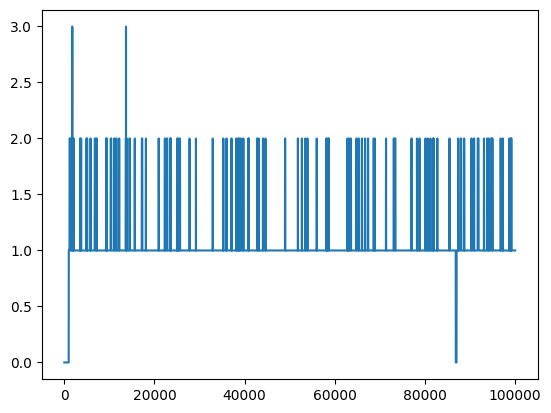

In [19]:
N_0 = 0
story = np.zeros(steps)

N_ = N_0
for i in range(steps):
    N_ = step(N_)
    story[i] = N_

print(np.mean(story), np.std(story), np.var(story)/np.mean(story)-1)

plt.plot(story)
plt.show()

In [36]:
N = 10
k_s = []
p_s = np.linspace(0, 1, 100)

for p in np.linspace(0, 1, 100):
    k_i = np.random.binomial(N, p, 1000)
    k_s.append(np.mean(k_i))


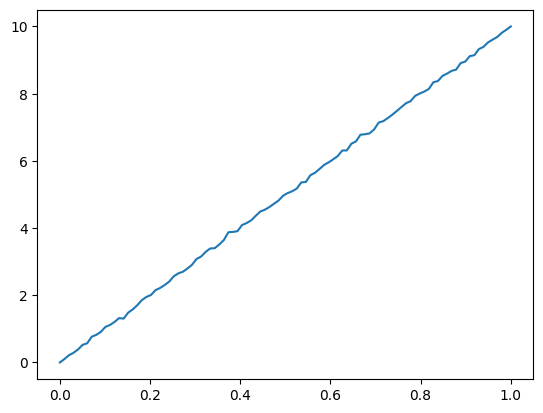

In [37]:
plt.plot(p_s, k_s)
plt.show()